In [12]:
import os

import numpy as np
import os.path as op
import pandas as pd

# https://arxiv.org/pdf/1905.02202.pdf

In [13]:
df = pd.read_csv("../4ply_data/skatevideosite/skaters_and_videos.csv")

# convert years from float to int
df.year.fillna(0, inplace=True)
df['year'] = df.year.astype(int)

In [14]:
# get count of unique skaters for each filmer
skaters_by_filmer = df.groupby(['filmmaker'])['title'].nunique()
filmers = skaters_by_filmer[skaters_by_filmer >= 3].index.values.tolist()

# limit data to filmmakers above threshold
df = df[df.filmmaker.isin(filmers)]

# limit data to desired columns
df = df[['filmmaker', 'year', 'title', 'skater']]

In [15]:
t = pd.DataFrame(df.filmmaker.value_counts())
t

,filmmaker
Beagle,154
Dan Wolfe,139
Aaron Meza,123
Jackson Casey,103
RB Umali,101
Ty Evans,87
Ewan Bowman,87
Nick vonWerssowetz,80
Jason Hernandez,79
Fred Mortagne,66


In [16]:
# .to_json('data2.json', orient='records')

In [17]:
filmer_unique_counts = df.groupby(['filmmaker'])['skater'].nunique()
filmer_counts = df.groupby(['filmmaker']).count()['skater']

In [18]:
ubiquity_index = np.round(filmer_counts / filmer_unique_counts, 2)
ubiquity_index

filmmaker
Aaron Meza              2.44
Beagle                  2.87
Bill Weiss              1.00
Brad Rosado             1.37
Chris Mulhern           1.12
Chris Ray               1.00
Chris Thiessen          1.05
Colin Kennedy           1.06
Colin Read              1.24
Dan Magee               1.83
Dan Wolfe               1.39
Dave Bergthold          1.21
Don Luong               1.40
Eduardo Muñoz           1.21
Ewan Bowman             1.39
Federico Vitetta        1.33
Fred Mortagne           2.28
Grant Yansura           1.50
Greg Hunt               1.26
Jackson Casey           2.40
Jacob Nunez             1.94
Jamie Thomas            1.53
Jason Hernandez         1.44
Jean-Jacques Briquet    1.03
Jeremy McNamara         1.05
Joe Castrucci           2.26
Jon Holland             1.00
Josh Beagle             1.18
Kevin Barnett           3.27
Matt Daughters          1.33
Matt Solomon            1.04
Mike Gilbert            1.21
Mike Manzoori           1.24
Nick vonWerssowetz      1.40
Patr

In [20]:
loyalty_index = pd.DataFrame(ubiquity_index.sort_values(ascending=False))
loyalty_index.columns = ['loyalty_index']
loyalty_index.reset_index(inplace=True)
loyalty_index.to_json('data/loyalty_index.json', orient='records')

In [22]:
filmer_df = df.groupby(['filmmaker', 'skater']).agg(
    {'skater': 'count'}
)

filmer_df.columns = ['cnt']
filmer_df.reset_index(inplace=True)
# filmer_df['skatekey'] = filmer_df.apply(lambda x: x['filmmaker'] + x['skater'], axis=1)
filmer_df

,filmmaker,skater,cnt
0,Aaron Meza,Alex Olson,4
1,Aaron Meza,Andrew Allen,3
2,Aaron Meza,Andrew Brophy,2
3,Aaron Meza,Anthony Pappalardo,2
4,Aaron Meza,Brian Anderson,7
...,...,...,...
1565,Yves Marchon,Phil Zwijsen,1
1566,Yves Marchon,Pirkka Pollari,3
1567,Yves Marchon,Ross McGouran,1
1568,Yves Marchon,Ruben Rodrigues,1


In [23]:
film_df = df.merge(filmer_df, on=['filmmaker', 'skater']).sort_values('cnt')

In [24]:
film_df

,filmmaker,year,title,skater,cnt
0,Mike Manzoori,2003,éS - Europe Tour 2003,Eric Koston,1
1478,Ewan Bowman,2009,Flip - Extremely Sorry,Christoph Wildgrube,1
1477,Ewan Bowman,2009,Flip - Extremely Sorry,Bob Burnquist,1
1474,Ewan Bowman,2012,Flip - The Weight of the World,Sebastian Gonzalez,1
1473,Ewan Bowman,2012,Flip - The Weight of the World,Oscar Meza,1
...,...,...,...,...,...
1259,Aaron Meza,2005,Fourstar - Fall/Holiday 2005 Catalog (SF),Eric Koston,10
1260,Aaron Meza,2005,Chocolate: Hittin' Britain & Oui Will Rock You,Eric Koston,10
1261,Aaron Meza,1999,The Chocolate Tour,Eric Koston,10
1252,Aaron Meza,2010,Girl/Anti Hero - Beauty and The Beast 3,Eric Koston,10


In [28]:
import json
def save_json(json_data, filename):
    """Save a file to json.
    """
    with open(filename, 'w') as fp:
        json.dump(json_data, fp)
        
def make_network_json(df):
    """Create JSON required for network visualization.
    
    Args:
        dist_df (pd.DataFrame): Dataframe representing site-by-site distance adjacency matrix.
    
    Returns:
        dict: JSON data for network visualization
    """
    json_data = {'nodes':[], 'links': []}
    skaters = df.skater.unique()
    # for each skater
    for source in skaters:
        # print videos in which skater occurred
        source_video = set(df[df.skater == source].title.unique())
        for target in skaters:
            target_video = set(df[df.skater == target].title.unique())
            # ignore same skater
            if source == target:
                continue
            # only join if in appeared in same video
            num_shared = len(source_video.intersection(target_video))
            if num_shared > 0:
                distance = num_shared * 10
                curr_site_links = {}
                curr_site_links['source'] = source
                curr_site_links['target'] = target
                curr_site_links['distance'] = distance
                json_data['links'].append(curr_site_links)

    # Add Nodes data
    for skater in df.skater.unique():
        skater_node = {}
        skater_node['id'] = skater
        skater_node['name'] = skater
        skater_node['cnt'] = str(df[df.skater == skater]['cnt'].values[0])
        json_data['nodes'].append(skater_node)
    return json_data

In [29]:
# 1. Subset data to region
filmers = film_df['filmmaker'].unique()

for part in filmers:
    print(part)
    file_path = './data/{}.json'.format(part.replace(" ", "_"))
    print(file_path)
    # get segment of data based on partition
    partition_df = film_df[film_df['filmmaker'] == part]
    # make network data from partition_df
    part_json = make_network_json(partition_df)
    ttt = part_json
    # save json
    save_json(part_json, file_path)

Mike Manzoori
./data/Mike_Manzoori.json
Ewan Bowman
./data/Ewan_Bowman.json
Josh Beagle
./data/Josh_Beagle.json
Don Luong
./data/Don_Luong.json
Jamie Thomas
./data/Jamie_Thomas.json
Mike Gilbert
./data/Mike_Gilbert.json
Fred Mortagne
./data/Fred_Mortagne.json
Matt Daughters
./data/Matt_Daughters.json
Aaron Meza
./data/Aaron_Meza.json
Spike Jonze
./data/Spike_Jonze.json
Federico Vitetta
./data/Federico_Vitetta.json
Ty Evans
./data/Ty_Evans.json
Roger Bagley
./data/Roger_Bagley.json
Dan Wolfe
./data/Dan_Wolfe.json
Colin Kennedy
./data/Colin_Kennedy.json
Beagle
./data/Beagle.json
Bill Weiss
./data/Bill_Weiss.json
Brad Rosado
./data/Brad_Rosado.json
Ricki Bedenbaugh
./data/Ricki_Bedenbaugh.json
Chris Ray
./data/Chris_Ray.json
Yves Marchon
./data/Yves_Marchon.json
Russell Houghten
./data/Russell_Houghten.json
Yoan Taillandier
./data/Yoan_Taillandier.json
Colin Read
./data/Colin_Read.json
Nick vonWerssowetz 
./data/Nick_vonWerssowetz_.json
Jason Hernandez
./data/Jason_Hernandez.json
Joe Cast

## Bag-of-Skaters

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
# replace spaces with _ for bag of words encoding
film_df['skater_filled'] = film_df.skater.apply(lambda x: x.replace(' ', '_'))

# get list of skaters for each filmer
filmer2skaters = film_df.groupby(['filmmaker'])['skater_filled'].apply(lambda x: ' '.join(x))

In [27]:
filmer2skaters = pd.DataFrame(filmer2skaters).reset_index()
filmer2skaters.columns = ['filmer', 'skater']

In [28]:
# Bag of Words encoding
vectorizer = CountVectorizer()
vectorizer.fit(filmer2skaters.skater)
vector = vectorizer.transform(filmer2skaters.skater)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(filmer2skaters.skater).todense()

pca = PCA(n_components=2).fit(X)

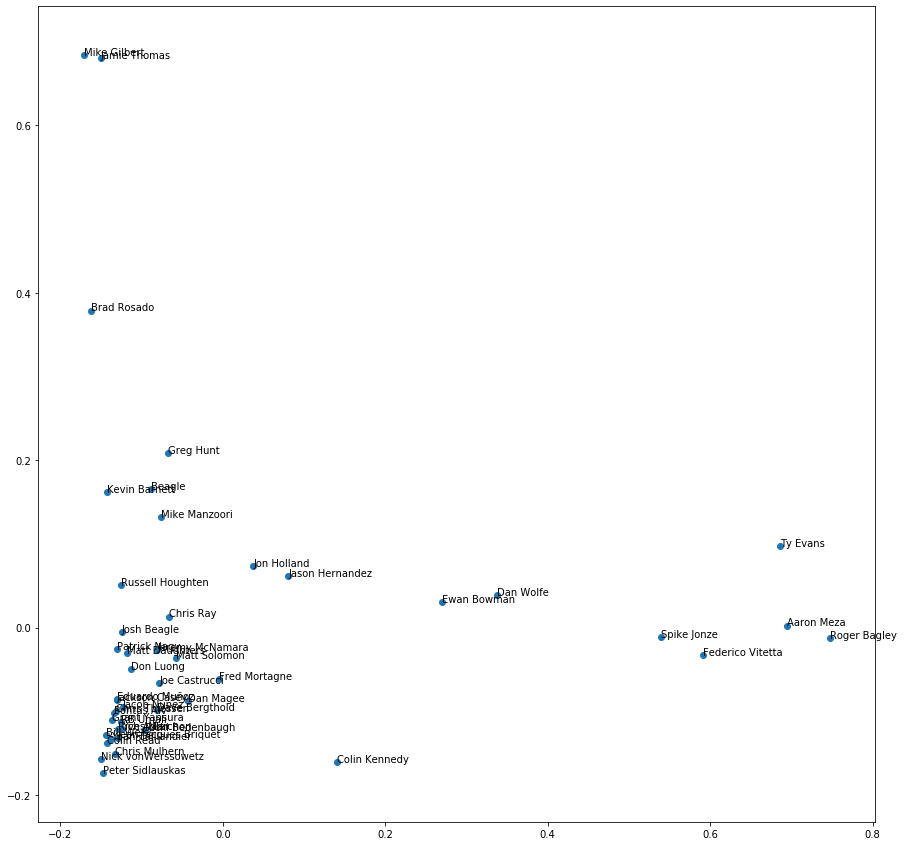

In [116]:
pca_embedding = pca.transform(X)

fig, ax = plt.subplots()
ax.scatter(pca_embedding[:,0], pca_embedding[:,1])

for i, txt in enumerate(filmer2skaters.filmer):
    ax.annotate(txt, (pca_embedding[i,0], pca_embedding[i,1]))
    
fig.set_figheight(15)
fig.set_figwidth(15)

In [44]:
sim_df = pd.DataFrame({
    'filmer': filmer2skaters.filmer,
    'comp1': pca_embedding[:, 0] + 1,
    'comp2': pca_embedding[:, 1] + 1
})

In [46]:
sim_df.to_csv('scatter_data.csv', index=False)

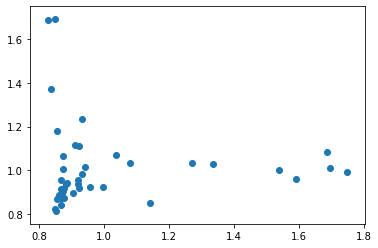

In [45]:
fig, ax = plt.subplots()
ax.scatter(sim_df.comp1, sim_df.comp2)

AttributeError: 'dict' object has no attribute 'columns'